In [ ]:
!apt -qq install p7zip-full
!pip install -q diffusers==0.31.0 transformers accelerate safetensors xformers gdown
!pip install -q moviepy imageio[ffmpeg] opencv-python-headless pillow
!pip install --upgrade scikit-video

p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 7.0 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/hzwer/Practical-RIFE.git
%cd /content/Practical-RIFE
!pip install -q moviepy akima scikit-image yacs
!gdown --id 1O5KfS3KzZCY3imeCr2LCsntLhutKuAqj -O model.zip
!7z e model.zip -o./train_log -aoa
!rm model.zip
%cd /content

Cloning into 'Practical-RIFE'...
remote: Enumerating objects: 625, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 625 (delta 372), reused 248 (delta 248), pack-reused 240 (from 2)
Receiving objects: 100% (625/625), 3.04 MiB | 7.90 MiB/s, done.
Resolving deltas: 100% (384/384), done.
/content/Practical-RIFE
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O5KfS3KzZCY3imeCr2LCsntLhutKuAqj
To: /content/Practical-RIFE/model.zip
100% 11.3M/11.3M [00:00<00:00, 68.3MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0

In [ ]:
import os
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, StableDiffusionImg2ImgPipeline
from diffusers.utils import load_image
from PIL import Image, ImageDraw
from moviepy.editor import ImageSequenceClip
import numpy as np
import csv
from transformers import CLIPProcessor, CLIPModel

# GPU Check
assert torch.cuda.is_available(), "GPU not available. Enable GPU runtime."
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create output directories
os.makedirs("/content/outputs/images", exist_ok=True)
os.makedirs("/content/outputs/frames", exist_ok=True)
os.makedirs("/content/outputs/video", exist_ok=True)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



AssertionError: GPU not available. Enable GPU runtime.

# Upload Your Own Sketch

Please upload your black and white sketch image (PNG, JPG, etc.).


Saving mann.jpg to mann.jpg

Successfully uploaded: 'mann.jpg'
Image has been saved to the required path: '/content/sketch.png'


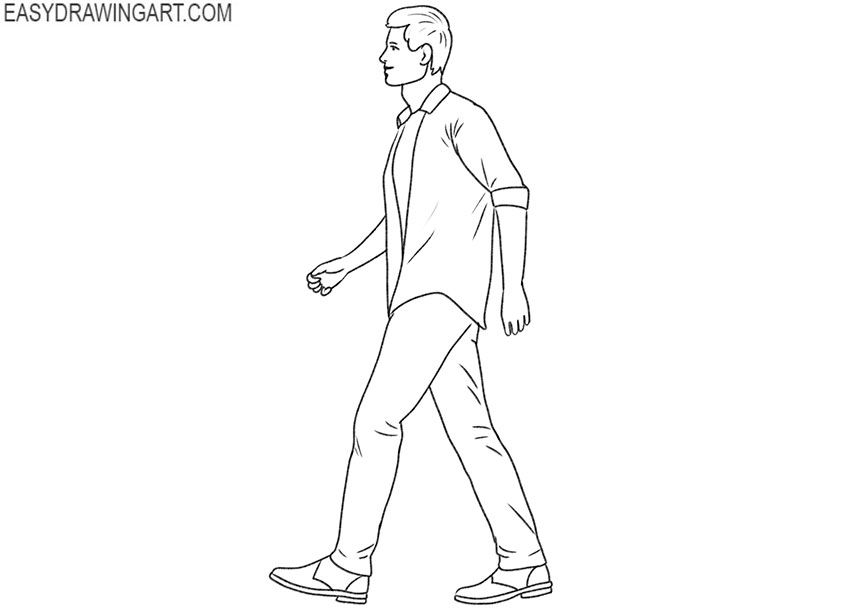

In [ ]:
from google.colab import files
from PIL import Image
import io

print("Please upload your black and white sketch image (PNG, JPG, etc.).")
uploaded = files.upload()

if not uploaded:
  raise ValueError("No file was uploaded. Please run the cell again.")
else:
  original_filename = list(uploaded.keys())[0]
  print(f"\nSuccessfully uploaded: '{original_filename}'")

  target_path = "/content/sketch.png"

  image_bytes = uploaded[original_filename]
  img = Image.open(io.BytesIO(image_bytes))

  img.save(target_path)

  print(f"Image has been saved to the required path: '{target_path}'")

  display(img)

# First Pass: Generate the Stylized Character

In [ ]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16)

pipeline_controlnet = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")
pipeline_controlnet.enable_xformers_memory_efficient_attention()

lora_repo_id = "sayakpaul/sd-model-finetuned-lora-t4"
print(f"Loading guaranteed public LoRA from: {lora_repo_id}")
pipeline_controlnet.load_lora_weights(lora_repo_id)

generator = torch.Generator(device="cuda").manual_seed(42)

prompt = "a drawing of a character, in the style of lora_pokemon, walking, full body, (plain white background:1.3)"
negative_prompt = "blurry, low quality, deformed, (grey background:1.2), splotchy background, gradient, texture, scene, ugly"
guidance_scale = 9.0

control_image = load_image("/content/sketch.png").convert("RGB")

stylized_image = pipeline_controlnet(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=control_image,
    num_inference_steps=30,
    guidance_scale=guidance_scale,
    controlnet_conditioning_scale=0.8,
    generator=generator
).images[0]

stylized_path = "/content/outputs/images/stylized.png"
stylized_image.save(stylized_path)

print("\nFirst Pass complete. The stylized 'hero' image is:")
display(stylized_image)

# Clean up memory
import gc
del pipeline_controlnet
del controlnet
gc.collect()
torch.cuda.empty_cache()

# Generate Key Frames with Scene Adaptation

In [ ]:
pipeline_animation = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")
pipeline_animation.enable_xformers_memory_efficient_attention()

print("Loading components for animation pipeline...")
pipeline_animation.load_lora_weights(lora_repo_id)
pipeline_animation.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.safetensors")
pipeline_animation.set_ip_adapter_scale(0.6)

prompt1 = "a drawing of a character, in the style of lora_pokemon, walking through a sunny forest"
prompt2 = "a drawing of a character, in the style of lora_pokemon, walking through a stormy night, rain"
negative_prompt = "blurry, low quality, deformed, ugly"

key_frames = []
init_image = stylized_image
num_frames = 10
half = num_frames // 2

normal_strength = 0.45
transition_strength = 0.65

generator = torch.Generator(device="cuda").manual_seed(42)

for i in range(num_frames):
    current_prompt = prompt1 if i < half else prompt2
    current_strength = transition_strength if i == half else normal_strength

    frame = pipeline_animation(
        prompt=current_prompt,
        negative_prompt=negative_prompt,
        image=init_image,
        strength=current_strength,
        ip_adapter_image=stylized_image,
        num_inference_steps=25,
        guidance_scale=7.5,
        generator=generator
    ).images[0]

    key_frames.append(frame)
    init_image = frame

    frame_path = f"/content/outputs/frames/frame_{i:04d}.png"
    frame.save(frame_path)
    print(f"Saved: {frame_path} (strength: {current_strength})")

print("\nAll key frames saved.")

# Clean up memory
del pipeline_animation
gc.collect()
torch.cuda.empty_cache()

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

#  Identity Check with CLIP Similarity

In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_similarity(ref, frame):
    inputs = clip_processor(images=[ref, frame], return_tensors="pt").to("cuda")
    with torch.no_grad():
        embs = clip_model.get_image_features(**inputs)
    return torch.nn.functional.cosine_similarity(embs[0:1], embs[1:2]).item()

csv_path = "/content/outputs/identity_log.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["frame_path", "similarity_score"])
    for i, frame in enumerate(key_frames):
        sim = compute_similarity(stylized_image, frame)
        writer.writerow([f"frame_{i:04d}.png", sim])
print(f"Identity log saved to: {csv_path}")

#  Create Low-FPS Keyframe Video

In [ ]:
frame_paths = [f"/content/outputs/frames/frame_{i:04d}.png" for i in range(num_frames)]
clip = ImageSequenceClip(frame_paths, fps=3)
keyframes_video = "/content/outputs/video/keyframes.mp4"
clip.write_videofile(keyframes_video, codec="libx264")
print(f"Keyframe video saved to: {keyframes_video}")


# Run RIFE Interpolation (with compatibility patch)

In [ ]:
import sys
import subprocess

pyfile = "/content/Practical-RIFE/inference_video.py"
with open(pyfile, "r") as f: src = f.read()
if "np.float" not in src:
    patch = "import numpy as np\nif not hasattr(np, 'float'): np.float = float\nif not hasattr(np, 'int'): np.int = int\n"
    with open(pyfile, "w") as f: f.write(patch + src)
    print("Patched RIFE script.")

%cd /content/Practical-RIFE
final_video_path = "/content/outputs/video/final_video.mp4"
command = [sys.executable, "inference_video.py", "--exp=3", f"--video={keyframes_video}", f"--output={final_video_path}"]
subprocess.run(command, check=True)
%cd /content

print(f"\nFinal interpolated video saved to: {final_video_path}")